In [97]:
# EMC2 WP 2 Processing 1.0  
# Filter on buildings with no dwellings  
# Author : Perez Joan

In [98]:
# 0.1 Packages, local filepaths & parameters
import geopandas as gpd
from shutil import copy

# In the folder used to record the main gpkg file & subset from 0.1 :
# Duplicate output from 0.1 to save results in 1.1 (subset)
copy("C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_0.1_Subset.gpkg", 
    "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_1.1_Subset.gpkg")

# Specify the file path to record the results
gpkg = "C:\\Users\\jperez\\Documents\\Current 1\\emc2\\Output\\WP2_DPC_1.1_Subset.gpkg"

# Read the data
building = gpd.read_file(gpkg, layer="building")
activity_areas = gpd.read_file(gpkg, layer="activity_areas")

In [99]:
# 1. Spatial join of categories of activity areas to buildings
building = building.rename(columns={'index_right': 'index_rgt'})
activity_areas = activity_areas.rename(columns={'index_right': 'index_rgt'})
building = gpd.sjoin(building, activity_areas[['categorie', 'geometry']], how='left', predicate='intersects')                                

In [100]:
# 2. Indexes to remove
# light buildings
indexes_1 = building[(building["construction_legere"] == True) & (building["nombre_de_logements"].isnull())].index
# Building with no dwelling
indexes_2 = building[building["nombre_de_logements"] == 0].index
# Specialized buildings
indexes_3 = building[(building["nature"] != "Indifférenciée") & (building["nombre_de_logements"].isnull())].index
# Building under construction (not in service)
indexes_4 = building[building["etat_de_l_objet"] != "En service"].index
# Annex buildings (official definition : Petit bâtiment à vocation d'annexe au sens fiscal : garage externe, abri...)
indexes_5 = building[(building["usage_1"] == "Annexe") & (building["nombre_de_logements"].isnull())].index
# Buildings with less the 10 m² of footprint 
indexes_6 = building[building.geometry.area < 10].index
# Large buildings within specialized areas with NULL values of dwellings
indexes_7 = building[(building.geometry.area > 150) & (building["nombre_de_logements"].isnull()) & (~building["categorie"].isnull())].index

In [101]:
# 3. merge indexes, remove duplicates & perform the filter
merged_idx = indexes_1.union(indexes_2).union(indexes_3).union(indexes_4).union(indexes_5).union(indexes_6).union(indexes_7)
filtered_building = building.drop(merged_idx)

In [102]:
# 4. Write a layer of buildings with dwellings (NA included) in output file
filtered_building.to_file(gpkg, layer="Buildings_with_dwellings_NA_included", driver="GPKG")

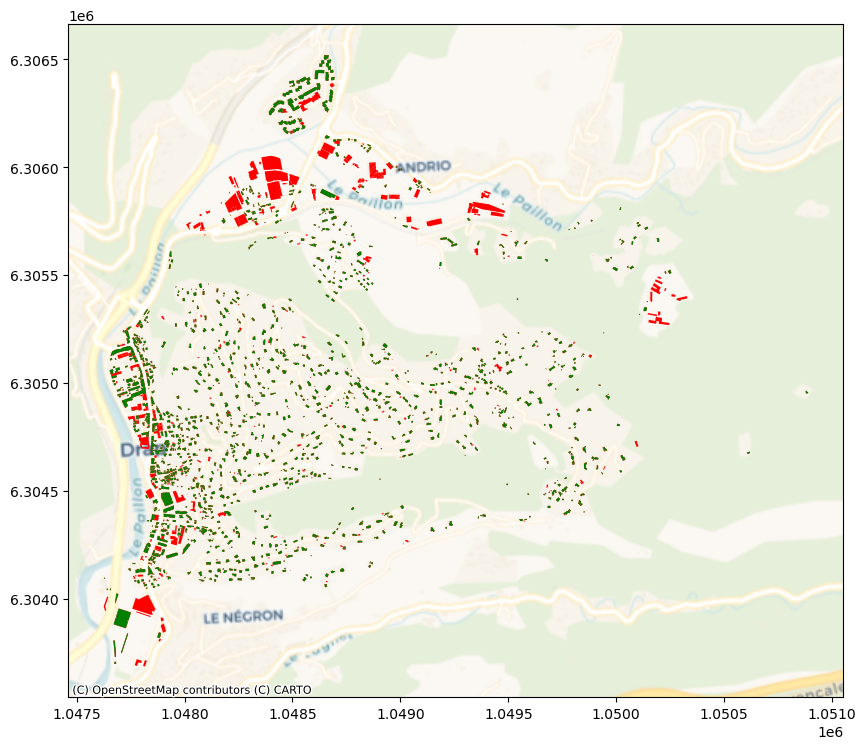

In [103]:
# Appendixes A1
import contextily
import folium
from folium.plugins import MarkerCluster
from ipyleaflet import Map, GeoData, basemaps, LayersControl

# Plot removed buildings in red
ax = building.plot(figsize=(10, 10), color='red')
# Plot kept buildings in green
filtered_building.plot(ax=ax, color='green')
# Add basemap
contextily.add_basemap(ax, crs=filtered_building.crs, source=contextily.providers.CartoDB.Voyager)

In [104]:
# Appendixes A2
# Removed and kept buildings - Mapview
from ipyleaflet import Map, GeoData, basemaps, LayersControl, Polygon
map = folium.Map(location=[43.7544, 7.3208], tiles="OpenStreetMap", zoom_start=14.5)
folium.GeoJson(building, color = "red").add_to(map)
folium.GeoJson(filtered_building, color = "green").add_to(map)
map